## Imports and Setup

In [16]:
%matplotlib inline
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from   sklearn.decomposition import TruncatedSVD
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from   sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [17]:
# class corpus metadata
metadata = pd.read_csv("class_corpus_metadata.csv")

metadata.shape

(160, 34)

In [18]:
metadata.head()

,Unnamed: 0,check_1,check_2,title,year,author1_surname,author1_givenname,author2_surname,author2_givenname,gender_author1,...,feminist fiction,mystery,adventure,tragedy,children,regency,manners,philosophical,coming-of-age,filename
0,nsg57,scw222,lcc82,"Writings in the United Amateur, 1915 - 1922",1922,Lovecraft,Howard,NaN,NaN,Male,...,False,True,False,False,False,False,False,True,False,Lovecraft_WritingsintheUnitedAmateur1915-1922.txt
1,fhh26,gs542,tj256,Whose Body?,1923,Sayers,Dorothy L.,NaN,NaN,Female,...,False,True,False,False,False,False,False,False,False,Sayres_WhoseBody.txt
2,cl2264,NaN,NaN,Voodoo Planet,1959,Norton,Andre,NaN,NaN,Female,...,False,False,True,False,False,False,False,False,False,Norton_VoodooPlanet.txt
3,ehh52,sjr255,kg428,"Varney the Vampire; Or, the Feast of Blood by ...",1845,Rymer,James Malcolm,Prest,Thomas Peckett,Male,...,False,False,False,False,False,False,False,False,False,Prest_Rhymer_VarneyTheVampire.txt
4,dgr73,jlp367,kg428,Uncle Tom's Cabin,1852,Stowe,Harriet Beecher,NaN,NaN,Female,...,False,False,False,False,False,False,False,False,False,Stowe_UncleTom_sCabin.txt


In [19]:
# training data are books that are either horror or detective
training_data = metadata[(metadata['horror']==True) | (metadata['detective']==True)]

# drop books that are both horror and detective
drop = metadata[(metadata['horror']==True) & (metadata['detective']==True)]
training_data = training_data.drop(drop.index)

# testing data are books are neither horror or detective
testing_data = metadata[(metadata['horror']==False) & (metadata['detective']==False)]

# sort titles alphabetically 
training_data = training_data.sort_values('title')
testing_data = testing_data.sort_values('title')
# note: training+testing+dropped row = 159 rows, class corpus = 160 rows, "An Unkindness of Ghosts" has no input for horror and detective column

In [20]:
training_data

,Unnamed: 0,check_1,check_2,title,year,author1_surname,author1_givenname,author2_surname,author2_givenname,gender_author1,...,feminist fiction,mystery,adventure,tragedy,children,regency,manners,philosophical,coming-of-age,filename
159,tl566,hz542,ja532,813,1910,Leblanc,Maurice,NaN,NaN,Male,...,False,True,False,False,False,False,False,False,False,Leblanc_813.txt
156,gc386,NaN,NaN,A Strange Disappearance,1998,Green,Anna Katharine,NaN,NaN,Female,...,False,True,False,False,False,False,False,False,False,GreenAnnaKatharine_AStrangeDisappearance.txt
155,nca28,tl566,stw43,A Study in Scarlet,1887,Conan Doyle,Arthur,NaN,NaN,Male,...,False,True,False,False,False,False,False,False,False,ConanDoyle_AStudyInScarlet.txt
153,jc2739,NaN,NaN,Agatha Webb,1899,Green,Anna Katharine,NaN,NaN,Female,...,False,True,False,False,False,False,False,False,False,Green_AgathaWebb.txt
146,lcc82,yk499,NaN,Carmilla,1872,Le_Fanu,Joseph Sheridan,NaN,NaN,Male,...,False,False,False,False,False,False,False,False,False,Carmilla.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,tr333,sjs457,sl2324,The Valley of Fear,1915,Doyle,Arthur Conan,NaN,NaN,Male,...,False,False,False,False,False,False,False,False,False,Doyle_TheValleyOfFear.txt
10,lrs263,sh785,hz542,The Wisdom of Father Brown,1914,Chesterton,Gilbert Keith,NaN,NaN,Male,...,False,False,False,False,False,False,False,False,False,Chesterton_TheWisdomOfFatherBrown.txt
3,ehh52,sjr255,kg428,"Varney the Vampire; Or, the Feast of Blood by ...",1845,Rymer,James Malcolm,Prest,Thomas Peckett,Male,...,False,False,False,False,False,False,False,False,False,Prest_Rhymer_VarneyTheVampire.txt
1,fhh26,gs542,tj256,Whose Body?,1923,Sayers,Dorothy L.,NaN,NaN,Female,...,False,True,False,False,False,False,False,False,False,Sayres_WhoseBody.txt


### There are 80 combined horror and detective novels in the corpus that we will use to train the classifier.

In [21]:
testing_data

,Unnamed: 0,check_1,check_2,title,year,author1_surname,author1_givenname,author2_surname,author2_givenname,gender_author1,...,feminist fiction,mystery,adventure,tragedy,children,regency,manners,philosophical,coming-of-age,filename
158,tr333,sjs457,sl2324,A Round Dozen,1883,Coolidge,Susan,NaN,NaN,Female,...,False,False,False,False,False,False,False,False,False,Coolidge_ARoundDozen.txt
157,kwy3,cl922,hk627,A Sicillian Romance,1790,Radcliffe,Ann Ward,NaN,NaN,Female,...,False,False,False,False,False,False,False,False,False,radcliffeann_a_sicillian_romance.txt
154,lqz4,gt294,lcc82,Adele Doring at Boarding-School,1921,North,Grace May,NaN,NaN,Female,...,False,False,False,False,True,False,False,False,False,adele_doring_boarding_school.txt
152,yc2669,xf89,wms87,Agnes Grey,1847,Bronte,Anne,NaN,NaN,Female,...,True,False,False,False,False,False,True,False,False,Bronte_AgnesGrey.txt
151,mn454,ar2465,jlp367,An Old-Fashioned Girl,1869,Alcott,Louisa May,NaN,NaN,Female,...,False,False,False,False,True,False,True,False,True,Alcott_AnOld-FashionedGirl.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,jc2739,NaN,NaN,This Side of Paradise,1920,Fitzgerald,F. Scott,NaN,NaN,Male,...,False,False,False,False,False,False,False,False,True,Fitzgerald_ThisSideOfParadise.txt
6,vs339,thh55,NaN,To Kill A Mockingbird,1960,Lee,Harper,NaN,NaN,Female,...,False,False,False,False,False,False,False,False,False,Lee_ToKillAMockingbird.txt
5,fhh26,gs542,tj256,Twenty Thousand Leagues Under the Sea,1870,Verne,Jules,NaN,NaN,Male,...,False,False,True,False,False,False,False,False,False,Verne_TwentyThousandLeagues.txt
4,dgr73,jlp367,kg428,Uncle Tom's Cabin,1852,Stowe,Harriet Beecher,NaN,NaN,Female,...,False,False,False,False,False,False,False,False,False,Stowe_UncleTom_sCabin.txt


### There are 78 combined novels from a variety of genres that are not horror or detective in the corpus.

In [22]:
# get book file names to open
training_names = training_data.filename.values
testing_names = testing_data.filename.values

In [23]:
print('First book in the training dataset:',training_names[0])
print('First book in the testing dataset:',testing_names[0])

First book in the training dataset: Leblanc_813.txt
First book in the testing dataset: Coolidge_ARoundDozen.txt


In [24]:
# 1=detective, 0=horror， gold labels
y_train=(training_data.detective.values*1).astype('int')

In [25]:
y_train

array([1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0])

In [26]:
# open and append training books together

training_books=[]
for book in training_names:
    with open(book, 'r',encoding='utf-8') as f:
        file = f.read().replace("\n", " ") 
        training_books.append(file)
        

In [27]:
# open and append testing books together

testing_books=[]
for book in testing_names:
    with open(book, 'r',encoding='utf-8') as f:
        file = f.read().replace("\n", " ") 
        testing_books.append(file)
        

### Vectorization, stopwords, normalization, standardization
an explanation. we really did try to not do arbitrary things

In [28]:
punct=[]
for x in string.punctuation:
    punct.append(x)
punct.append('--')
punct.append('`')
punct.append("“")
punct.append("”")

In [29]:
# Custom preprocessing to remove escaped characters in input, taken from MP02
def pre_proc(x):
    '''
    Takes a unicode string.
    Lowercases, strips accents, and removes some escapes.
    Returns a standardized version of the string.
    '''
    import unicodedata
    return unicodedata.normalize('NFKD', x.replace("\'", "'").replace("\ in\ form", " inform").lower().strip())

# Set up vectorizer

vectorizer = TfidfVectorizer(
    encoding='utf-8',
    preprocessor=pre_proc,
   # stop_words=punct,
    min_df=2, # Note this
    max_df=0.8, # This, too
    binary=False,
    norm='l2',
    use_idf=True, # And this,
    #max_features=10000
)

# Your code here
X_train = vectorizer.fit_transform(training_books)
print("Matrix shape:", X_train.shape)

Matrix shape: (80, 30376)


In [30]:
#standardization
X_train_Z = StandardScaler(with_mean=False).fit_transform(X_train)
display(X_train_Z)
print('z-scored l2 mean:', round(np.mean(X_train_Z),3))
np.std(X_train)

<80x30376 sparse matrix of type '<class 'numpy.float64'>'
	with 376031 stored elements in Compressed Sparse Row format>

z-scored l2 mean: 0.292


ValueError: setting an array element with a sequence.

### Classifier

In [41]:
# Examine the performance of our simple classifiers
# Freebie function to summarize and display classifier scores
def compare_scores(scores_dict):
    '''
    Takes a dictionary of cross_validate scores.
    Returns a color-coded Pandas dataframe that summarizes those scores.
    '''
    df = pd.DataFrame(scores_dict).T.applymap(np.mean).style.background_gradient(cmap='RdYlGn')
    return df

We are choosing Multinomial NB, logistic, for reasons x and y. our thought process cuz we shouldnt use the multinomial because you should appreciate that we are actually thinking instead of copying and pasting mp 02 thank you
we are smart and realize that class_prior is not good for reasons

In [59]:
vect_n=[]
mm=[]
matrix_n= {}
feat_n = [100, 5000,10000,15000,17500,20000,22500,25000,30000,35000]
for x in feat_n:
    vectorizer = TfidfVectorizer(
        encoding='utf-8',
        preprocessor=pre_proc,
        min_df=2, # Note this
        max_df=0.8, # This, too
        binary=False,
        norm='l2',
        use_idf=True, # And this
        max_features=x)
    vect_n.append(vectorizer)
    matrix = vectorizer.fit_transform(training_books)
    #print('z-scored l2 mean:', round(np.mean(X_train_Z),3))
    dict_key=str(x)
    matrix_n[dict_key] = matrix
    mm.append(matrix)
    #matrix="matrix"+str(x)
  #  matrix = vectorizer.fit_transform(training_books)


In [32]:
matrix_n

{'5000': <80x5000 sparse matrix of type '<class 'numpy.float64'>'
 	with 187794 stored elements in Compressed Sparse Row format>,
 '10000': <80x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 274957 stored elements in Compressed Sparse Row format>,
 '15000': <80x15000 sparse matrix of type '<class 'numpy.float64'>'
 	with 320917 stored elements in Compressed Sparse Row format>,
 '17500': <80x17500 sparse matrix of type '<class 'numpy.float64'>'
 	with 335934 stored elements in Compressed Sparse Row format>,
 '20000': <80x20000 sparse matrix of type '<class 'numpy.float64'>'
 	with 347813 stored elements in Compressed Sparse Row format>,
 '22500': <80x22500 sparse matrix of type '<class 'numpy.float64'>'
 	with 357000 stored elements in Compressed Sparse Row format>,
 '25000': <80x25000 sparse matrix of type '<class 'numpy.float64'>'
 	with 364318 stored elements in Compressed Sparse Row format>,
 '30000': <80x30000 sparse matrix of type '<class 'numpy.float64'>'
 	with 375

##### Multinomial Naive Bayes

In [33]:
nb_classifiers = {
    'M NB Default, Alpha=1':MultinomialNB(alpha = 1),
   # 'M NB fit_prior=False':MultinomialNB(fit_prior = False),
}

scores = {} # Store cross-validation results in a dictionary
for matrix in matrix_n: 
    scores[matrix] = cross_validate( # perform cross-validation
        MultinomialNB(alpha = 1), # classifier object
        matrix_n[matrix], # feature matrix
        y_train, # gold labels
        cv=10, #number of folds
        scoring=['accuracy','precision', 'recall', 'f1', 'f1_macro', 'f1_micro'] # scoring methods
    )

In [42]:
compare_scores(scores)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
5000,0.002203,0.002948,0.662500,0.655357,1.000000,0.790842,0.445421,0.662500
10000,0.001718,0.002605,0.662500,0.655357,1.000000,0.790842,0.445421,0.662500
15000,0.002003,0.002655,0.662500,0.655357,1.000000,0.790842,0.445421,0.662500
17500,0.001992,0.002686,0.662500,0.655357,1.000000,0.790842,0.445421,0.662500
20000,0.002070,0.002727,0.662500,0.655357,1.000000,0.790842,0.445421,0.662500
22500,0.002213,0.002776,0.662500,0.655357,1.000000,0.790842,0.445421,0.662500
25000,0.002230,0.002754,0.662500,0.655357,1.000000,0.790842,0.445421,0.662500
30000,0.002334,0.002817,0.662500,0.655357,1.000000,0.790842,0.445421,0.662500
35000,0.002329,0.002801,0.662500,0.655357,1.000000,0.790842,0.445421,0.662500


In [70]:
vect1 = TfidfVectorizer(
        encoding='utf-8',
        preprocessor=pre_proc,
        min_df=2, # Note this
        max_df=0.8, # This, too
        binary=False,
        norm='l2',
        use_idf=True)# And this
        #max_features=0000)

In [71]:
X_train = vect1.fit_transform(training_books)
X_train_Z = StandardScaler(with_mean=False).fit_transform(X_train)

In [72]:
classifiers = {
    'lg1': LogisticRegression()  ,
    'mnb': MultinomialNB()
}



scores = {} # Store cross-validation results in a dictionary
for classifier in classifiers: 
    scores[classifier] = cross_validate( # perform cross-validation
        classifiers[classifier], # classifier object
        X_train_Z, # feature matrix
        y_train, # gold labels
        cv=10, #number of folds
        scoring=['accuracy','precision', 'recall', 'f1', 'f1_macro', 'f1_micro'] # scoring methods
    )
    

In [73]:
compare_scores(scores)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
lg1,0.421886,0.002540,0.775000,0.756548,1.000000,0.855012,0.667506,0.775000
mnb,0.002376,0.002778,0.887500,0.868095,0.980000,0.917879,0.867273,0.887500


In [141]:
vectorizer.fit_transform(training_books)

<80x30376 sparse matrix of type '<class 'numpy.float64'>'
	with 376031 stored elements in Compressed Sparse Row format>

[<80x5000 sparse matrix of type '<class 'numpy.float64'>'
 	with 187794 stored elements in Compressed Sparse Row format>,
 <80x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 274957 stored elements in Compressed Sparse Row format>,
 <80x15000 sparse matrix of type '<class 'numpy.float64'>'
 	with 320917 stored elements in Compressed Sparse Row format>,
 <80x17500 sparse matrix of type '<class 'numpy.float64'>'
 	with 335934 stored elements in Compressed Sparse Row format>,
 <80x20000 sparse matrix of type '<class 'numpy.float64'>'
 	with 347813 stored elements in Compressed Sparse Row format>,
 <80x22500 sparse matrix of type '<class 'numpy.float64'>'
 	with 357000 stored elements in Compressed Sparse Row format>,
 <80x25000 sparse matrix of type '<class 'numpy.float64'>'
 	with 364318 stored elements in Compressed Sparse Row format>,
 <80x30000 sparse matrix of type '<class 'numpy.float64'>'
 	with 375279 stored elements in Compressed Sparse Row format>,
 <80x30376 sparse

In [37]:
all_books=training_books+testing_books

In [38]:
vis=vectorizer.fit_transform(all_books)

In [39]:
labels=np.hstack((y_train, y_test))

In [576]:
training_data['shape']='train'
testing_data['shape']='test'
books_order=pd.concat([training_data, testing_data])
books_order['y']=labels
books_order['gender_author1']=books_order['gender_author1'].str.lower()
books_order.head()

,Unnamed: 0,check_1,check_2,title,year,author1_surname,author1_givenname,author2_surname,author2_givenname,gender_author1,...,tragedy,children,regency,manners,philosophical,coming-of-age,filename,shape,y_pred,y
0,tl566,hz542,ja532,813,1910,Leblanc,Maurice,NaN,NaN,male,...,False,False,False,False,False,False,Leblanc_813.txt,train,NaN,1
1,gc386,NaN,NaN,A Strange Disappearance,1998,Green,Anna Katharine,NaN,NaN,female,...,False,False,False,False,False,False,GreenAnnaKatharine_AStrangeDisappearance.txt,train,NaN,1
2,nca28,tl566,stw43,A Study in Scarlet,1887,Conan Doyle,Arthur,NaN,NaN,male,...,False,False,False,False,False,False,ConanDoyle_AStudyInScarlet.txt,train,NaN,1
3,jc2739,NaN,NaN,Agatha Webb,1899,Green,Anna Katharine,NaN,NaN,female,...,False,False,False,False,False,False,Green_AgathaWebb.txt,train,NaN,1
4,lcc82,yk499,NaN,Carmilla,1872,Le_Fanu,Joseph Sheridan,NaN,NaN,male,...,False,False,False,False,False,False,Carmilla.txt,train,NaN,0


#### To start, we decided to visualize all of the books in one graph to see where they stood in relation to each other. We separated them based on genre and training/testing data. The blue dots are true and predicted horror novels, while the orange dots are true and predicted detective novels. In addition, the points marked with a dot are books from our training data and points marked with an 'x' are from our testing data. 

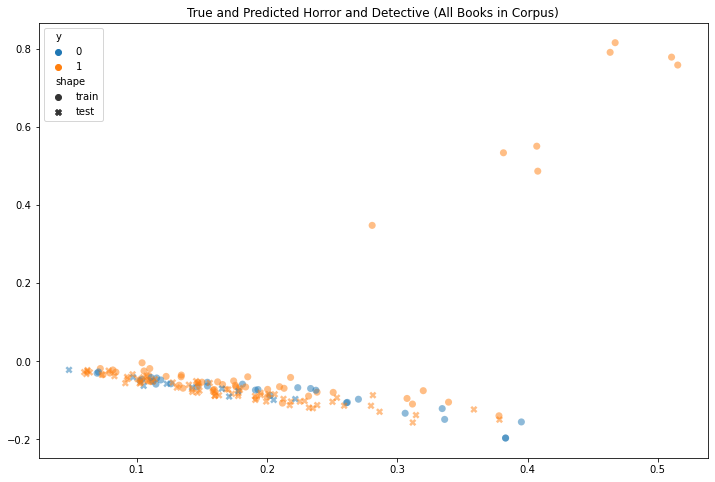

In [578]:
# source: mp2
coords_books = TruncatedSVD(n_components=2).fit_transform(vis)

plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=coords_books[:, 0], 
    y=coords_books[:, 1],
    hue=books_order['y'],
    style=books_order['shape'],
    alpha=0.5,
    s=50,
    linewidth=0
)
plt.title('True and Predicted Horror and Detective (All Books in Corpus)')
plt.show()

#### After plotting all the books, we saw that there were eight outlying books which we will not consider for our recommendations because there are no testing books that are similar to them, and thus no recommendations can be made using them. However, upon further investigation of the eight outlying points, we discovered that they are all books in the Sherlock Holmes series written by Sir Arthur Conan Doyle. There are nine instances of Doyle books in our class corpus, and the only one not included in our outliers is'Micah Clarke' which is not part of the Sherlock Holmes series. This makes sense as the Sherlock Holmes series would likely have many similarities, being written by the same author and dealing with the same characters. In addition, as Franco Moretti suggests in 'The Slaughterhouse of Literature', Conan stumbled upon the unique characteristic of clues while working on the myth of Sherlock Holmes, which would likely set it apart from the rest of the novels, even in the detective genre (215).

In [587]:
books_order['x_c']=coords_books[:,0]
books_order['y_c']=coords_books[:,1]
no_out=books_order[books_order['y_c']<.3]

In [591]:
out=books_order[books_order['y_c']>.3].title.values
print('List of outliers in the corpus\n:',out)

List of outliers in the corpus
: ['A Study in Scarlet' 'His Last Bow' 'The Adventures of Sherlock Holmes'
 'The Hound of the Baskervilles' 'The Memoirs of Sherlock Holmes'
 'The Return of Sherlock Holmes' 'The Sign of Four' 'The Valley of Fear']


In [599]:
print('All Doyle Books in Class Corpus:')
books_order[(books_order['author1_surname']=='Doyle') | (books_order['author1_surname']=='Conan Doyle') ].sort_values('year')

All Doyle Books in Class Corpus:


,Unnamed: 0,check_1,check_2,title,year,author1_surname,author1_givenname,author2_surname,author2_givenname,gender_author1,...,regency,manners,philosophical,coming-of-age,filename,shape,y_pred,y,x_c,y_c
2,nca28,tl566,stw43,A Study in Scarlet,1887,Conan Doyle,Arthur,NaN,NaN,male,...,False,False,False,False,ConanDoyle_AStudyInScarlet.txt,train,NaN,1,0.407829,0.486733
18,yld3,NaN,NaN,Micah Clarke,1889,Doyle,Arthur Conan,NaN,NaN,male,...,False,False,False,False,Doyle_MicahClarke.txt,test,1.0,1,0.281255,-0.086764
20,dk564,NaN,NaN,The Adventures of Sherlock Holmes,1892,Doyle,Conan,NaN,NaN,male,...,False,False,False,False,Doyle_The Adventures of Sherlock Holmes.txt,train,NaN,1,0.510544,0.778657
48,yz2685,pav35,avb37,The Memoirs of Sherlock Holmes,1893,Conan Doyle,Arthur,NaN,NaN,male,...,False,False,False,False,memoirs_of_sherlock_holmes.txt,train,NaN,1,0.515285,0.758406
32,ss3697,gt294,jk2345,The Hound of the Baskervilles,1902,Conan Doyle,Arthur,NaN,NaN,male,...,False,False,False,False,Doyle_TheHoundOfThe Baskervilles.txt,train,NaN,1,0.381482,0.533800
61,sh785,sc2538,sl2324,The Return of Sherlock Holmes,1905,Doyle,Arthur Conan,NaN,NaN,male,...,False,False,False,False,the_return_of_sherlock_holmes.txt,train,NaN,1,0.467240,0.815624
75,tr333,sjs457,sl2324,The Valley of Fear,1915,Doyle,Arthur Conan,NaN,NaN,male,...,False,False,False,False,Doyle_TheValleyOfFear.txt,train,NaN,1,0.280690,0.347977
14,lqz4,gt294,lcc82,His Last Bow,1917,Conan Doyle,Arthur,NaN,NaN,male,...,False,False,False,False,his_last_bow.txt,train,NaN,1,0.463386,0.790943
69,yy596,st848,gar234,The Sign of Four,2000,Doyle,Arthur,NaN,NaN,male,...,False,False,False,False,Doyle_TheSignoftheFour.txt,train,NaN,1,0.407055,0.550672


#### In order to get recommendations, however, we need to see the points that are very similar to each other, so we decided that we had to subset the graph by restricting the coordinate points to only the large group of data the bottom. First we decided to plot all the books together, and then we subsetted again based on genre to get a better sense of the books that were the most similar to each other.

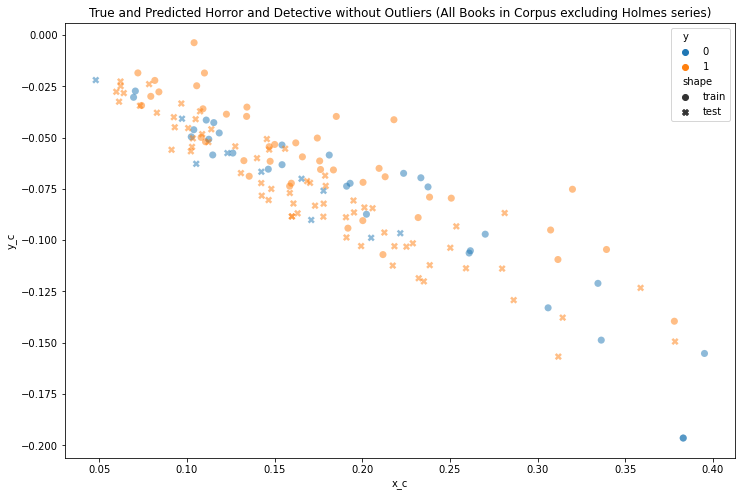

In [600]:
plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=no_out['x_c'],
    y=no_out['y_c'],
    hue=no_out['y'],
    style=no_out['shape'],
    alpha=0.5,
    s=50,
    linewidth=0
)

#ax2 = plt.axes([]
plt.title('True and Predicted Horror and Detective without Outliers (All Books in Corpus excluding Holmes series)')
plt.show()

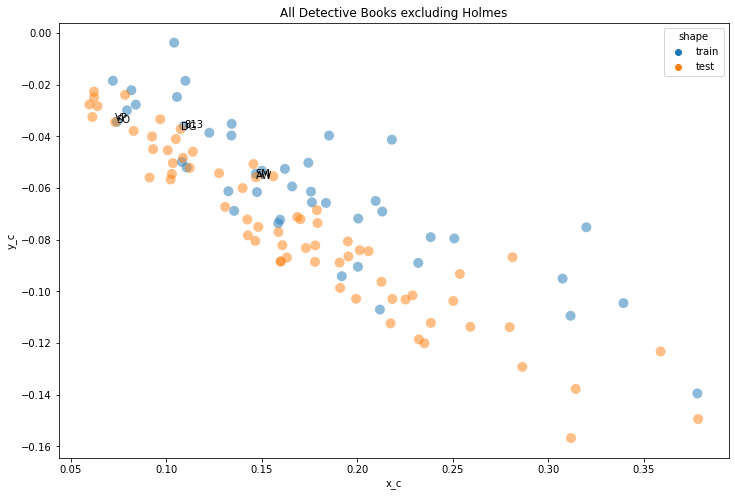

In [602]:
# only detective books

all_det=no_out[no_out['y']==1]
plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=all_det['x_c'],
    y=all_det['y_c'],
    #hue=no_out['y'],
    hue=all_det['shape'],
    alpha=0.5,
    s=100,
    linewidth=0,
)
plt.text(x=0.107421, y=-0.037324, s='DG')
plt.text(x=0.109162, y=-0.036519, s='813')
plt.text(x=0.146958, y=-0.056449, s='AW')
plt.text(x=0.146810, y=-0.055745, s='SM')
plt.text(x=0.073134, y=-0.033966, s='VP')
plt.text(x=0.074059, y=-0.034657, s='SO')




plt.title('All Detective Books excluding Holmes')
plt.show()

In [85]:
print('An example of a pair of books in the detective genre:')
all_det[(all_det['y_c']>-.06)&(all_det['y_c']<-.055)&(all_det['x_c']<.155)&(all_det['x_c']>.145)]

,Unnamed: 0,check_1,check_2,title,year,author1_surname,author1_givenname,author2_surname,author2_givenname,gender_author1,...,regency,manners,philosophical,coming-of-age,filename,shape,y_pred,y,x_c,y_c
3,jc2739,NaN,NaN,Agatha Webb,1899,Green,Anna Katharine,NaN,NaN,female,...,False,False,False,False,Green_AgathaWebb.txt,train,NaN,1,0.147030,-0.055073
33,ss3697,gt294,jk2345,Silas Marner,1861,Eliot,George,NaN,NaN,female,...,False,False,False,False,Eliot_SilasMarner.txt,test,1.0,1,0.146838,-0.055969


#### Using this graph of only the detective books (excluding Holmes books), we singled out three pairs of overlapping points. Each pair of points has one book that has a true label of detective and one book that has a true label of 'other', but a predicted label of detective. Because the book that has a true label of 'other' has such similar coordinates to the true detective book, we can recommend that particular book to those that are a fan of the detective genre. 
#### The pairs are: 
- Secret of the Old Clock (train) and the Voodoo Planet (test - recommendation)
- 813 by Maurice LeBlanc (train) and The Picture of Dorian Gray (test - recommendation)
- Agatha Webb (train) and Silas Marner (test - recommendation)


#### We then repeated the process for the horror genre.

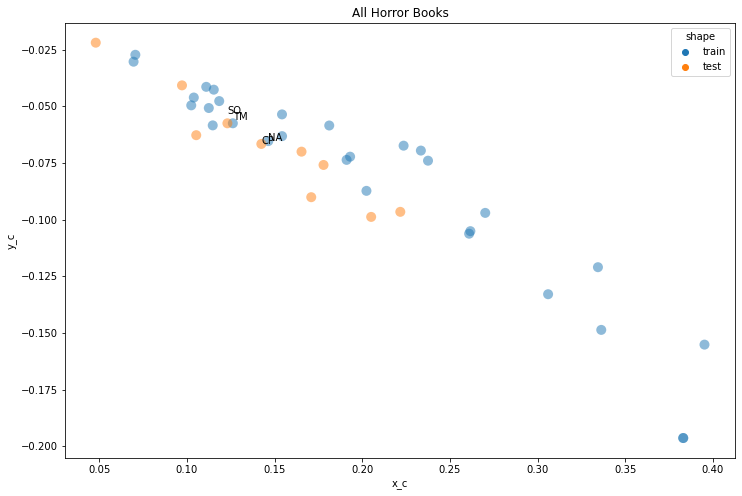

In [603]:
all_hor=books_order[books_order['y']==0]
plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=all_hor['x_c'],
    y=all_hor['y_c'],
   # hue=no_out['y'],
    hue=all_hor['shape'],
    alpha=0.5,
    s=100,
    linewidth=0
)
plt.text(x=0.142446, y=-0.066692, s='CP')
plt.text(x=0.146354, y=-0.065167, s='NA')
plt.text(x=0.126121, y=-0.056002, s='TM')
plt.text(x=0.122982, y=-0.053425, s='SO')
plt.title('All Horror Books')
plt.show()

#### For the horror genre, we were able to single out two different pairs of overlapping points and are thus able to give two recommendations. 
#### The pairs are: 
- Northanger Abbey (train) and Chaplet of Pearls (test - recommendation)
- The Man (train) and The Lances of Lynwood (test - recommendation)

In [87]:
print('An example of a pair of books in the horror genre:')
all_hor[(all_hor['y_c']>-.075)&(all_hor['y_c']<-.05)&(all_hor['x_c']<.14)&(all_hor['x_c']>.12)]

,Unnamed: 0,check_1,check_2,title,year,author1_surname,author1_givenname,author2_surname,author2_givenname,gender_author1,...,regency,manners,philosophical,coming-of-age,filename,shape,y_pred,y,x_c,y_c
45,tj256,mn454,ab2226,The Man,1905,Stoker,Bram,NaN,NaN,male,...,False,False,False,False,stoker_theman.txt,train,NaN,0,0.126121,-0.056002
55,avb37,ss3697,yw783,The Lances of Lynwood,1855,Yonge,Charlotte M,NaN,NaN,female,...,False,False,False,False,CMYonge_Lances_Lynwood.txt,test,0.0,0,0.122982,-0.053425


#### Our full list of recommendations is as follows:

In [88]:
rec_titles=['The Man','The Secret of the Old Clock','Voodoo Planet','813','The Picture of Dorian Gray','Agatha Webb','Silas Marner','Northanger Abbey','Chaplet Of Pearls','The Lances of Lynwood']
book_recs=books_order[books_order['title'].isin(rec_titles)]

In [89]:
book_recs

,Unnamed: 0,check_1,check_2,title,year,author1_surname,author1_givenname,author2_surname,author2_givenname,gender_author1,...,regency,manners,philosophical,coming-of-age,filename,shape,y_pred,y,x_c,y_c
0,tl566,hz542,ja532,813,1910,Leblanc,Maurice,NaN,NaN,male,...,False,False,False,False,Leblanc_813.txt,train,NaN,1,0.109166,-0.036708
3,jc2739,NaN,NaN,Agatha Webb,1899,Green,Anna Katharine,NaN,NaN,female,...,False,False,False,False,Green_AgathaWebb.txt,train,NaN,1,0.147030,-0.055073
18,yy596,st848,gar234,Northanger Abbey,1994,Austen,Jane,NaN,NaN,female,...,False,False,False,False,Austen_NorthangerAbbey.txt,train,NaN,0,0.146357,-0.065577
45,tj256,mn454,ab2226,The Man,1905,Stoker,Bram,NaN,NaN,male,...,False,False,False,False,stoker_theman.txt,train,NaN,0,0.126121,-0.056002
67,thh55,aj656,gc386,The Secret of the Old Clock,1930,Keene,Carolyn,NaN,NaN,female,...,False,False,False,False,keene_secretoftheoldclock.txt,train,NaN,1,0.074076,-0.034807
8,yld3,mab583,NaN,Chaplet Of Pearls,1868,Yonge,Charlotte Mary,NaN,NaN,female,...,False,False,False,False,Yonge_ChapletOfPearls.txt,test,0.0,0,0.142419,-0.067262
33,ss3697,gt294,jk2345,Silas Marner,1861,Eliot,George,NaN,NaN,female,...,False,False,False,False,Eliot_SilasMarner.txt,test,1.0,1,0.146838,-0.055969
55,avb37,ss3697,yw783,The Lances of Lynwood,1855,Yonge,Charlotte M,NaN,NaN,female,...,False,False,False,False,CMYonge_Lances_Lynwood.txt,test,0.0,0,0.122982,-0.053425
63,aac64,lrs263,stw43,The Picture of Dorian Gray,1890,Wilde,Oscar,NaN,NaN,male,...,False,False,True,False,wilde-the-picture-of-dorian-gray.txt,test,1.0,1,0.107482,-0.037805
77,cl2264,NaN,NaN,Voodoo Planet,1959,Norton,Andre,NaN,NaN,female,...,False,False,False,False,Norton_VoodooPlanet.txt,test,1.0,1,0.073105,-0.034554


### Result: Genres 

In [621]:
genres = ['title', 'shape', 'horror', 'detective', 'sci-fi', 'fantasy', 'romantic', 'gothic', 'historical',
       'feminist fiction', 'mystery', 'adventure', 'tragedy', 'children',
       'regency', 'manners', 'philosophical', 'coming-of-age']

genre_recs=book_recs[genres]
genre_recs

,title,shape,horror,detective,sci-fi,fantasy,romantic,gothic,historical,feminist fiction,mystery,adventure,tragedy,children,regency,manners,philosophical,coming-of-age
8,Chaplet Of Pearls,test,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
33,Silas Marner,test,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
55,The Lances of Lynwood,test,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
63,The Picture of Dorian Gray,test,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False
77,Voodoo Planet,test,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False


#### Looking a the genres of the books recommendations, 
